In [175]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit, vectorize, float64, int64
import stahmctestt as stt
import random
%matplotlib inline

### In this case, we assumed that gradient is known, we want to show here that for highly correlated posterior, SGMHC performs better than SGLD

In [195]:
#the sampler for sghmc
def hmc(theta0,grad,M,C,epsilon,iter=1000):
    """
    This function outputs the p dimiension SGHMC samples.    
    Args: 
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient function injected with noise
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        iter: iteration number, 1000 by default
    """
    random.seed(300)
    p=theta0.shape[0]
    r=np.random.multivariate_normal(np.zeros(p),M).reshape(p,1)
    theta=theta0
    theta_save=np.zeros([p,iter])
    r_save=np.zeros([p,iter])
    for t in range(iter):    
        theta=theta+epsilon*(np.linalg.inv(M) @ r)
        r=r-(grad(theta))*epsilon-epsilon*(C @ np.linalg.inv(M) @ r)+np.random.multivariate_normal(np.zeros(p),2*epsilon*C,1).T
        theta_save[:,t]=theta.ravel()
        r_save[:,t]=r.ravel()
    return theta_save,r_save

In [204]:
#the sampler for sgld
def sgld(theta0,grad,M,C,epsilon,iter=1000):
    """
    This function outputs the p dimiension SGLD samples.    
    Args: 
        theta0: the initial point of theta, the parameter of interest
        grad: the gradient of the potential
        M: the mass
        C: the C term, where C*M^{-1} is the friction
        epsilon: stepsize
        iter: iteration number, 1000 by default
    """
    random.seed(300)
    p=theta0.shape[0]
    theta=theta0
    theta_save=np.zeros([p,iter])
    r_save=np.zeros([p,iter])
    for t in range(iter):    
        theta=theta-(grad(theta))*epsilon+np.random.multivariate_normal(np.zeros(p),2*epsilon*np.identity(p),1).T
        theta_save[:,t]=theta.ravel()
    return theta_save

In [205]:
###Rerun the example in Figure 3 
#Assume that posterior sample came from a highly correlated bivariate normal
random.seed(300)
theta0=np.array([0,0]).reshape([2,1])
M=np.array([[1,0],[0,1]])
C=np.array([[1,0],[0,1]])
grad=lambda theta:  np.linalg.inv(np.array([[1,.95],[.95,1]])) @ theta+np.random.multivariate_normal(np.zeros(2),np.identity(2)).reshape([2,1])
epsilon=.1
theta_save_hmc, r_save_hmc=hmc(theta0,grad,M,C,epsilon,iter=100)
theta_save_sgld=sgld(theta0,grad,M,C,epsilon,iter=100)

In [206]:
# the gradient 
Siginv=np.linalg.inv(np.array([[1,.95],[.95,1]]))

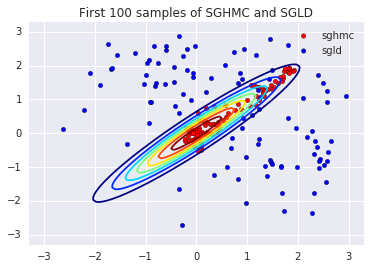

In [207]:
# plot how two method explore space
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z=1/2/np.pi*np.exp(-.5*(Siginv[0,0]*X**2+Siginv[1,1]*Y**2+2*Siginv[1,0]*X*Y))
plt.contour(X,Y,Z, cmap='jet')
plt.scatter(theta_save_hmc[0,:],theta_save_hmc[1,:],c='red')
plt.scatter(theta_save_sgld[0,:],theta_save_sgld[1,:],c='blue')
plt.legend(['sghmc','sgld'])
plt.title('First 100 samples of SGHMC and SGLD')
pass